# Predictive Performance Evaluation of Gears
This section is based on the methodology of the Gears paper. It evaluates the predictive performance of Gears on the top 5000 highly variable genes (HVGs) and top 20 genes across five default datasets: Norman, Adamson, Dixit, and others, using the exact same methods as in the original study.

### Importing necessary libraries

In [1]:
from gears import PertData, GEARS
import scanpy as sc
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import requests
import scipy as sp

### Some necessary custom functions for calculating MSE (Mean Squared Error) and plotting

The `cal_l2_error` function calculates the L2 norm error between predicted and actual gene expression values under different perturbations. Initially, it creates dataframes for predicted and actual values, labeling each entry with its perturbation type. The function then calculates the average gene expression for each type of perturbation, subtracting the control group's mean to isolate the effect of the perturbations. Subsequently, it computes the L2 norm of the error between the predicted and actual expressions and sorts these errors.

**After grouping based on perturbation**
1. **Average Perturbation Effect:**

    For each perturbation group \( p \):
$$
\text{Average Effect}_{(\text{pred}, HVG), p} = \frac{1}{n_p} \sum_{i=1}^{n_p} y_{(\text{pred}, HVG), i}
$$
$$
\text{Average Effect}_{(\text{truth}, HVG), p} = \frac{1}{n_p} \sum_{i=1}^{n_p} y_{(\text{truth}, HVG), i}
$$

- $Y_{(\text{pred, HVG}),i}$: The predicted highly variable gene expression value for the $i$-th sample.

- $Y_{(\text{truth, HVG}),i}$: The true highly variable gene expression value for the $i$-th sample.

- $n_p$: The total number of samples in perturbation gropu $p$.

2. **Perturbation Effect:**
$$
\text{Perturbation Effect}_{(\text{pred}, HVG), p} = \text{Average Effect}_{(\text{pred}, HVG), p} - \text{control\_mean}
$$
$$
\text{Perturbation Effect}_{(\text{truth}, HVG), p} = \text{Average Effect}_{(\text{truth}, HVG), p} - \text{control\_mean}
$$

- $\text{control\_mean}$: The average highly variable gene expression value for the control group.

3. **L2 Norm Error:**
$$
\text{L2 Error}_p = \sqrt{\sum_{j=1}^{n_{\text{genes}}} \left( \text{Perturbation Effect}_{(\text{pred}, HVG), p, j} - \text{Perturbation Effect}_{(\text{truth}, HVG), p, j} \right)^2}
$$

- $n_{\text{genes}}$: The number of highly variable genes.

- $j$: The index of a gene.

- $p$: For each perturbation group.

In [2]:
def cal_l2_error(y_pred, y_truth, perturbations, control_mean):
    """
    Calculate the L2 norm error for gene expression predictions compared to the ground truth.

    Parameters:
    - y_pred: Predicted gene expression values, shape (n_samples, n_genes)
    - y_truth: True gene expression values, shape (n_samples, n_genes)
    - perturbations: List of perturbations, length n_samples
    - control_mean: Mean expression of the control group, shape (1, n_genes)

    Returns:
    - A Pandas Series containing the sorted L2 norm error for each perturbation group, indexed by the perturbation labels. The values are sorted in descending order.
    """

    # Create a dataframe to associate perturbations with y_pred and y_truth
    df_pred = pd.DataFrame(y_pred)
    df_pred['perturbation'] = perturbations

    df_truth = pd.DataFrame(y_truth)
    df_truth['perturbation'] = perturbations

    # Function to compute the average gene expression for each perturbation group
    def calculate_average_effect(df):
        avg_effect = df.groupby('perturbation').mean()
        return avg_effect

    # Compute average effect for each perturbation
    avg_pred = calculate_average_effect(df_pred)
    avg_truth = calculate_average_effect(df_truth)

    # Subtract control group effect to get the perturbation effect
    perturbation_effect_pred = avg_pred.subtract(control_mean, axis=1)
    perturbation_effect_truth = avg_truth.subtract(control_mean, axis=1)

    # Calculate L2 norm of error
    l2_norm_error = np.linalg.norm(perturbation_effect_pred - perturbation_effect_truth, axis=1)

    # Sort L2 norm error by descending order and reindex the barplot data
    sorted_l2_norm_error = pd.Series(l2_norm_error, index=perturbation_effect_pred.index).sort_values(ascending=False)

    return sorted_l2_norm_error

The `cal_l2_error_top20` function calculates the L2 error for each perturbation by comparing the average predicted and true gene expression values, specifically focusing on the top 20 dynamically changing genes per cell. This function is an adaptation of `cal_l2_error`, designed to handle scenarios where the control group expressions are provided for each sample and need to be averaged per perturbation group.(Top 20 genes are different for each perturbed gene) The function first calculates the average gene expression for each perturbation group in the predicted, true, and control datasets. Then, it computes the perturbation effects by subtracting the averaged control expressions from the averaged predicted and true gene expressions for each perturbation group. Finally, it calculates the L2 norm of the differences between the perturbation effects of the predicted and true expressions for each perturbation group. The results are sorted in descending order based on the L2 errors.

**After grouping based on perturbation**

1. **Average Gene Expression:**

    For each perturbation group \( p \):

$$
\text{Average Predicted Expression}_{p} = \frac{1}{n_p} \sum_{i=1}^{n_p} y_{\text{pred}, i}
$$

$$
\text{Average True Expression}_{p} = \frac{1}{n_p} \sum_{i=1}^{n_p} y_{\text{truth}, i}
$$

$$
\text{Average Control Expression}_{p} = \frac{1}{n_p} \sum_{i=1}^{n_p} y_{\text{control}, i}
$$

- $y_{\text{pred}, i}$: Predicted gene expression values for the $i$-th sample.
- $y_{\text{truth}, i}$: True gene expression values for the $i$-th sample.
- $y_{\text{control}, i}$: Control gene expression values for the $i$-th sample.
- $n_p$: Number of samples in perturbation group $p$.

2. **Perturbation Effect:**

$$
\text{Perturbation Effect}_{\text{pred}, p} = \text{Average Predicted Expression}_{p} - \text{Average Control Expression}_{p}
$$

$$
\text{Perturbation Effect}_{\text{truth}, p} = \text{Average True Expression}_{p} - \text{Average Control Expression}_{p}
$$

3. **L2 Norm Error:**

$$
\text{L2 Error}_p = \sqrt{ \sum_{j=1}^{n_{\text{genes}}} \left( \text{Perturbation Effect}_{\text{pred}, p, j} - \text{Perturbation Effect}_{\text{truth}, p, j} \right)^2 }
$$

- $n_{\text{genes}}$: Number of genes (e.g., top 20 expressed genes).
- $j$: Index of a gene.
- $p$: Each perturbation group.

In [3]:
def cal_l2_error_top20(y_pred, y_truth, perturbations, expression_top20):
    """
    Calculate the average L2 error for each perturbation, taking into account the top 20 expressed genes.

    Parameters:
    - y_pred: Predicted gene expression values, shape (n_samples, n_genes)
    - y_truth: True gene expression values, shape (n_samples, n_genes)
    - perturbations: List of perturbations, length n_samples
    - expression_top20: Expression values of the top 20 genes for the control group, shape (n_samples, n_genes)

    Returns:
    - sorted_l2_norm_error: Average L2 errors sorted in descending order, indexed by perturbation name
    """

    # Create a dataframe to associate perturbations with y_pred, y_truth, and expression_top20
    df_pred = pd.DataFrame(y_pred)
    df_pred['perturbation'] = perturbations

    df_truth = pd.DataFrame(y_truth)
    df_truth['perturbation'] = perturbations

    df_control = pd.DataFrame(expression_top20)
    df_control['perturbation'] = perturbations

    # Function to compute the average gene expression for each perturbation group
    def calculate_average_effect(df):
        avg_effect = df.groupby('perturbation').mean()
        return avg_effect

    # Compute average effect for each perturbation
    avg_pred = calculate_average_effect(df_pred)
    avg_truth = calculate_average_effect(df_truth)
    avg_control = calculate_average_effect(df_control)

    # Subtract control group effect to get the perturbation effect
    perturbation_effect_pred = avg_pred.subtract(avg_control, axis=1)
    perturbation_effect_truth = avg_truth.subtract(avg_control, axis=1)

    # Calculate L2 norm of error
    l2_norm_error = np.linalg.norm(perturbation_effect_pred - perturbation_effect_truth, axis=1)

    # Sort L2 norm error by descending order and reindex
    sorted_l2_norm_error = pd.Series(l2_norm_error, index=perturbation_effect_pred.index).sort_values(ascending=False)

    return sorted_l2_norm_error

The `plot_outcome` function visualizes the L2 norm errors from multiple methods using both bar plots and box plots. In the first subplot, it creates a bar plot where errors for each method are displayed side by side. In the second subplot, it generates a box plot to show the distribution of L2 norm errors for each method, providing insights into variance and outliers.

In [4]:
def plot_outcome(l2_norm_errors):

    # Create barplot and boxplot
    plt.figure(figsize=(12, 6))

    # Barplot for L2 norm of error
    plt.subplot(1, 2, 1)
    # for method_name, errors in l2_norm_errors.items():
    #     plt.bar(errors.index, errors)
    # plt.title('L2 Norm of Error for Each Perturbation')
    # plt.xticks(rotation=90)

    # Determine the x-axis positions
    x = np.arange(len(next(iter(l2_norm_errors.values())).index))  
    bar_width = 0.2  # Set the width of each bar
    offset = 0  # Initial offset value

    # Assign an offset for each method's bars to prevent overlap
    for i, (method_name, errors) in enumerate(l2_norm_errors.items()):
        plt.bar(x + offset, errors, width=bar_width, label=method_name)
        offset += bar_width  # Increment the offset for the next method's bars

    # Set title and labels
    plt.title('L2 Norm of Error for Each Perturbation')
    plt.xticks(x + bar_width * (len(l2_norm_errors) - 1) / 2, next(iter(l2_norm_errors.values())).index, rotation=90)
    plt.legend()
    plt.tight_layout()

    # Boxplot for L2 norm of error
    plt.subplot(1, 2, 2)
    boxplot_data = [l2_norm_errors[method_name] for method_name in l2_norm_errors.keys()]
    plt.boxplot(boxplot_data, labels=l2_norm_errors.keys())
    plt.title('Boxplot of L2 Norm of Error')

    plt.tight_layout()
    plt.show()

The `convert_predictions_to_dataframe` function transforms a list of predictions, which can be NumPy arrays or dictionaries, into a pandas DataFrame. It iterates through each element in the list, extracts data based on the type of element, and appends it to a new list. This list is then used to create a DataFrame, effectively structuring the prediction results for further analysis.

In [5]:
def convert_predictions_to_dataframe(predictions):
    # Create an empty list to store data for DataFrame
    data = []

    # Iterate over each NumPy array in the list
    for pred in predictions:
        if isinstance(pred, dict):
            # If pred is a dictionary, extract values from the dict
            for values in pred.values():
                data.append(values)
        elif isinstance(pred, np.ndarray):
            # If pred is an array, append it directly
            data.append(pred)

    # Create DataFrame from extracted data
    df = pd.DataFrame(data)

    return df

### Step 1: Load Preprocessed Data, Train Model, and Load Pretrained Model

In [6]:
# get data
pert_data = PertData('./data')
# load dataset in paper: norman, adamson, dixit, replogle_rpe1_essential, replogle_k562_essential
pert_data.load(data_name = 'adamson')
# specify data split
pert_data.prepare_split(split = 'simulation', seed = 1)
# get dataloader with batch size
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

# set up and train a model
gears_model = GEARS(pert_data, device = 'cpu')
#gears_model.model_initialize(hidden_size = 64)
#gears_model.train(epochs = 30)

# save/load model
#gears_model.save_model('gears_adamson')
gears_model.load_pretrained('gears_adamson')

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['SRPR+ctrl' 'SLMO2+ctrl' 'TIMM23+ctrl' 'AMIGO3+ctrl' 'KCTD16+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:21
Done!
Creating dataloaders....
Done!


here1


### Step 2: Get predicted values and true values on the full HVG, compare them with the blank, calculate the L2 norm, and plot the results

In [7]:
# Extract the name of gene A to be predicted from 'A+ctrl' in the test set
genes_to_predict = []
conditions = pert_data.set2conditions['test']
for condition in conditions:
    if '+ctrl' in condition or 'ctrl+' in condition:
        parts = condition.split('+')
        for part in parts:
            if part != 'ctrl':
                genes_to_predict.append(part)

print("Genes to Predict:")
print(genes_to_predict)

Genes to Predict:
['CREB1', 'BHLHE40', 'DDIT3', 'HARS', 'DAD1', 'DDRGK1', 'SAMM50', 'CAD', 'GNPNAT1', 'TTI2', 'MANF', 'TARS', 'EIF2B2', 'ARHGAP22', 'SRP72', 'TMED10', 'COPB1', 'FECH', 'DHDDS', 'CARS', 'TMED2']


In the training set, the code filters out samples from the control group and calculates the mean value to determine the average gene expression of the control group, referred to as 'control mean', with a shape of (1, n_genes). For the test set, it filters samples containing perturbations and uses the model to predict gene expressions. It extracts gene names from conditions such as A+ctrl or ctrl+A and stores the predicted values. Finally, it retrieves the actual gene expressions from the test set.

In [8]:
train_conditions = pert_data.set2conditions['train']
test_conditions = pert_data.set2conditions['test']
train_samples = pert_data.adata[pert_data.adata.obs['condition'].isin(train_conditions)]
control_mean = train_samples.X[train_samples.obs['condition'] == 'ctrl', :].toarray().mean(axis=0)

Y_pred_test_gears = []

test_samples = pert_data.adata[pert_data.adata.obs['condition'].isin(test_conditions)]
test_samples = test_samples[test_samples.obs['condition'].str.contains('\+ctrl|ctrl\+')]

perturbations = test_samples.obs['condition'].tolist()

for gene in perturbations:   # predict every gene in test set
    name = [part for part in gene.split('+') if part != 'ctrl'][0]  # extract the gene name A from A+ctrl or ctrl+A
    all_predict = gears_model.predict([[name]])
    Y_pred_test_gears.append(all_predict)

Y_true_test = test_samples.X.toarray()

The code converts the prediction array `Y_pred_test_gears` into a pandas DataFrame using the function `convert_predictions_to_dataframe` for easier analysis, assigns this DataFrame to `Y_pred_test_gears_new` for further use, and transforms the true values array `Y_true_test` into a DataFrame.

In [9]:
df_pred = convert_predictions_to_dataframe(Y_pred_test_gears)
Y_pred_test_gears_new = df_pred
Y_true_test = pd.DataFrame(Y_true_test)

Compare with the blank(control mean) and plot on the full Highly Variable Genes (HVG)

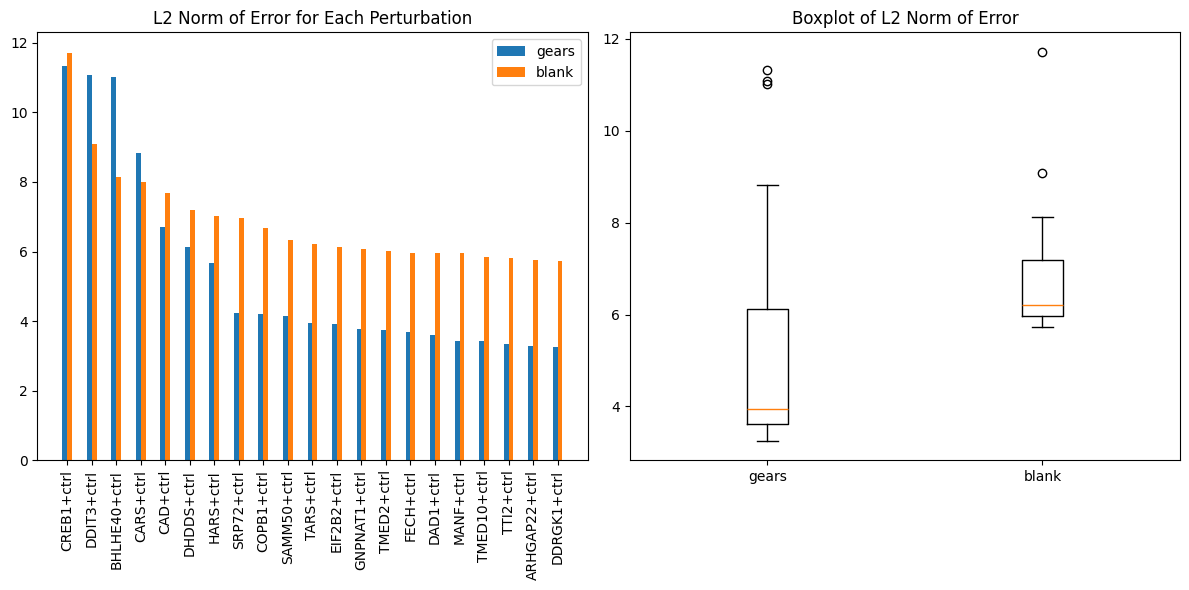

In [10]:
l2_norm_error_gears = cal_l2_error(Y_pred_test_gears_new, Y_true_test, perturbations, control_mean)

Y_pred_test_blank = np.zeros_like(Y_true_test) + control_mean
l2_norm_error_blank = cal_l2_error(Y_pred_test_blank, Y_true_test, perturbations, control_mean)

l2_norm_errors_test = {}
l2_norm_errors_test['gears'] = l2_norm_error_gears
l2_norm_errors_test['blank'] = l2_norm_error_blank

plot_outcome(l2_norm_errors_test)

In [11]:
print({method: l2_norm_errors_test[method].mean() for method in l2_norm_errors_test.keys()})

{'gears': np.float32(5.3700924), 'blank': np.float32(6.8722744)}


### Step 3: Get predicted values and true values on the top_non_zero_de_20 genes, compare them with the blank, calculate the L2 norm, and plot the results

In [12]:
pert_data.adata.obs.head(10)

,condition,cell_type,dose_val,control,condition_name
cell_barcode,,,,,
AAACATACACCGAT-1,CREB1+ctrl,K562(?),1+1,0,K562(?)_CREB1+ctrl_1+1
AAACATACAGAGAT-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACATACCAGAAA-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACATACGTTGAC-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACATACTGTTCT-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACCGTGCAGCTA-1,ZNF326+ctrl,K562(?),1+1,0,K562(?)_ZNF326+ctrl_1+1
AAACCGTGCCTGAA-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACCGTGCGGAGA-1,ctrl,K562(?),1,1,K562(?)_ctrl_1
AAACCGTGGAACTC-1,CREB1+ctrl,K562(?),1+1,0,K562(?)_CREB1+ctrl_1+1


#### Oringinal Version(Can be skipped):

This code iterates over each perturbation in the test set, extracts the corresponding gene name and the top 20 differentially expressed genes, converts these gene names to indices, and then uses the GEARS model to predict the expression levels of these genes. It collects the predicted expressions, the true expression values from the test samples, and calculates the average expression of these genes in the control group from the training samples, appending all these results to their respective lists for further analysis.

**However, in each iteration of the for loop, the predicted values, true values, and control mean are calculated repeatedly, which leads to redundant computations and slow performance. Therefore, an improved version is provided below, which significantly enhances the execution speed. Tests confirm that the results of both versions are identical. This code is still retained for reference.**

In [ ]:
# ## Build a mapping from gene_id to index
# gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(pert_data.gene_names.index)}
#     ## gene_id_to_idx:
#     ## {'ENSG00000228463': 0,
#     ##  'ENSG00000272438': 1,
#     ##  'ENSG00000230699': 2,
#     ##  'ENSG00000223764': 3,
#     ##  ...
#     ##  'ENSG00000223791': 996,
#     ##  'ENSG00000224074': 997,
#     ##  'ENSG00000151090': 998,
#     ##  'ENSG00000272554': 999,
#     ##  ...}

# Y_pred_test_gears_top20= []
# Y_true_test_gears_top20 = []
# control_mean_top20 = []
# k = 0
# for pert in perturbations:
#     ## Extract gene names
#     raw_condition_name = pert_data.adata.obs.loc[
#         pert_data.adata.obs['condition'] == pert, 'condition_name'
#     ].unique()[0] # like K562(?)_CREB1+ctrl_1+1

#     part = raw_condition_name.split('_')[1] # like CREB1+ctrl
#     gene_parts = part.split('+')
#     condition_name = [part for part in gene_parts if 'ctrl' not in part][0] # gene name, like CREB1
    
#     ## Get the top 20 genes
#     top_genes = pert_data.adata.uns['top_non_zero_de_20'][raw_condition_name]
#         ## top genes looks like:
#         ## array(['ENSG00000100347', 'ENSG00000112306', 'ENSG00000197756',
#         ## 'ENSG00000145592', 'ENSG00000108107', 'ENSG00000135404',
#         ## 'ENSG00000171858', 'ENSG00000233927', 'ENSG00000089248',
#         ## 'ENSG00000166710', 'ENSG00000213741', 'ENSG00000177954',
#         ## 'ENSG00000149516', 'ENSG00000105193', 'ENSG00000172270',
#         ## 'ENSG00000134419', 'ENSG00000124172', 'ENSG00000124614',
#         ## 'ENSG00000093010', 'ENSG00000132386'], dtype=object)

#     ## Convert gene names to indices
#     gene_indices = [gene_id_to_idx[gene_id] for gene_id in top_genes if gene_id in gene_id_to_idx]
#         ## gene_indices looks like: [4979, 1929, 910, 1481, 4853, 3277, 4533, 4614, 3380, 3721, 3576, 355, 2987, 4742, 4553, 3917, 4528, 1822, 4878, 4063]
    
#     ## Extract the predicted top 20 gene expressions
#     pred_expr = gears_model.predict([[condition_name]])
#     pred_top_genes = pred_expr[condition_name][gene_indices]
#         ## pred_top_genes looks like:
#         ## array([0.57601863, 4.2403755 , 2.9866006 , 3.072369  , 3.6987996 ,
#         ##        2.7795196 , 2.4965951 , 2.4036705 , 2.3769205 , 3.2209272 ,
#         ##        1.7740251 , 2.8834126 , 2.4417973 , 3.8578947 , 2.9965417 ,
#         ##        3.7931442 , 2.48152   , 2.5777972 , 2.4987907 , 0.82577777],
#         ##       dtype=float32)
#     Y_pred_test_gears_top20.append(pred_top_genes)

#     ## Get true expression values
#     true_expr = test_samples.X[k, gene_indices].toarray().flatten()
#     Y_true_test_gears_top20.append(true_expr)

#     ## Calculate the average expression of the top20 genes in the control group
#     control_expr_top20 = train_samples.X[
#         train_samples.obs['condition'] == 'ctrl', :
#     ].toarray()[:, gene_indices]

#     ctrl_mean_top20 = control_expr_top20.mean(axis=0)
#     control_mean_top20.append(ctrl_mean_top20)
#     k+=1

#### Advanced Version:

##### Part 1
This code precomputes essential information for each unique perturbation to optimize subsequent computations. It builds a mapping from gene IDs to indices, initializes result lists and caching dictionaries, and iterates over all unique perturbations. For each perturbation, it extracts the gene name, retrieves the top 20 differentially expressed genes, converts these gene names to their corresponding indices, computes the mean expression of these genes in the control group, stores all this information in a dictionary (`pert_info`), and caches the prediction results from the GEARS model to avoid redundant computations.

In [13]:
# Build a mapping from gene_id to index
gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(pert_data.gene_names.index)}
    ## gene_id_to_idx:
    ## {'ENSG00000228463': 0,
    ##  'ENSG00000272438': 1,
    ##  'ENSG00000230699': 2,
    ##  'ENSG00000223764': 3,
    ##  ...
    ##  'ENSG00000223791': 996,
    ##  'ENSG00000224074': 997,
    ##  'ENSG00000151090': 998,
    ##  'ENSG00000272554': 999,
    ##  ...}

# Initialize result lists
Y_pred_test_gears_top20 = []
Y_true_test_gears_top20 = []
control_mean_top20 = []

# Initialize mapping dictionary and prediction result cache
pert_info = {}
condition_name_to_pred = {}

# Get all unique perturbation conditions
unique_perts = set(perturbations)

# Precompute necessary information and prediction results
for pert in unique_perts:
    # Get the corresponding condition names
    raw_condition_name = pert_data.adata.obs.loc[
        pert_data.adata.obs['condition'] == pert, 'condition_name'
    ].unique()[0]  # like K562(?)_CREB1+ctrl_1+1
    
    # Extract gene name
    part = raw_condition_name.split('_')[1]
    gene_parts = part.split('+')
    condition_name = [part for part in gene_parts if 'ctrl' not in part][0]  # gene name, like CREB1
    
    # Get the top 20 genes
    top_genes = pert_data.adata.uns['top_non_zero_de_20'][raw_condition_name]
        ## top genes looks like:
        ## array(['ENSG00000100347', 'ENSG00000112306', 'ENSG00000197756',
        ## 'ENSG00000145592', 'ENSG00000108107', 'ENSG00000135404',
        ## 'ENSG00000171858', 'ENSG00000233927', 'ENSG00000089248',
        ## 'ENSG00000166710', 'ENSG00000213741', 'ENSG00000177954',
        ## 'ENSG00000149516', 'ENSG00000105193', 'ENSG00000172270',
        ## 'ENSG00000134419', 'ENSG00000124172', 'ENSG00000124614',
        ## 'ENSG00000093010', 'ENSG00000132386'], dtype=object)
    
    # Convert gene names to indices
    gene_indices = [gene_id_to_idx[gene_id] for gene_id in top_genes if gene_id in gene_id_to_idx]
        ## gene_indices looks like: [4979, 1929, 910, 1481, 4853, 3277, 4533, 4614, 3380, 3721, 3576, 355, 2987, 4742, 4553, 3917, 4528, 1822, 4878, 4063]
    
    # Compute the mean expression of top20 genes in the control group
    control_expr_top20 = train_samples.X[
        train_samples.obs['condition'] == 'ctrl', :
    ].toarray()[:, gene_indices]
    ctrl_mean_top20_sample = control_expr_top20.mean(axis=0)
    
    # Store information in the dictionary
    pert_info[pert] = {
        'condition_name': condition_name,
        'gene_indices': gene_indices,
        'ctrl_mean_top20': ctrl_mean_top20_sample
    }
    
    # Cache prediction results
    if condition_name not in condition_name_to_pred:
        pred_expr_full = gears_model.predict([[condition_name]])
        pred_expr = pred_expr_full[condition_name]
        condition_name_to_pred[condition_name] = pred_expr


##### Part 2
In this part, the code iterates over the test samples and their corresponding perturbation conditions. For each sample, it retrieves the precomputed information from the dictionaries, appends the control group's mean expression to the list, obtains the cached prediction result for the condition, extracts the predicted expressions for the top 20 genes, and adds them to the result list. It also retrieves the true expression values of these genes from the test samples and appends them to the corresponding list for further analysis.

In [14]:
# Iterate over test samples and their corresponding perturbation conditions
for idx, pert in enumerate(perturbations):
    # Retrieve precomputed information
    info = pert_info[pert]
    condition_name = info['condition_name']
    gene_indices = info['gene_indices']
    ctrl_mean_top20_sample = info['ctrl_mean_top20']
    
    # Add to the control_mean_top20 list
    control_mean_top20.append(ctrl_mean_top20_sample)
    
    # Get cached prediction result
    pred_expr = condition_name_to_pred[condition_name]
    
    # Extract predicted expression of the top 20 genes
    pred_top_genes = pred_expr[gene_indices]
    Y_pred_test_gears_top20.append(pred_top_genes)
    
    # Get true expression values
    true_expr = test_samples.X[idx, gene_indices].toarray().flatten()
    Y_true_test_gears_top20.append(true_expr)

**Why This Version Runs Much Faster:**

This version runs significantly faster because it eliminates redundant computations by precomputing and caching data. By calculating gene indices, control mean expressions, and model predictions upfront for each unique perturbation, it avoids recalculating these values multiple times within the loop over test samples. This reduces computational overhead and improves efficiency, leading to a substantial increase in execution speed compared to the previous version.

In [15]:
Y_pred_test_gears_top20_new = pd.DataFrame(Y_pred_test_gears_top20)
Y_true_test_gears_top20_new = pd.DataFrame(Y_true_test_gears_top20)
control_mean_top20_new = pd.DataFrame(control_mean_top20)

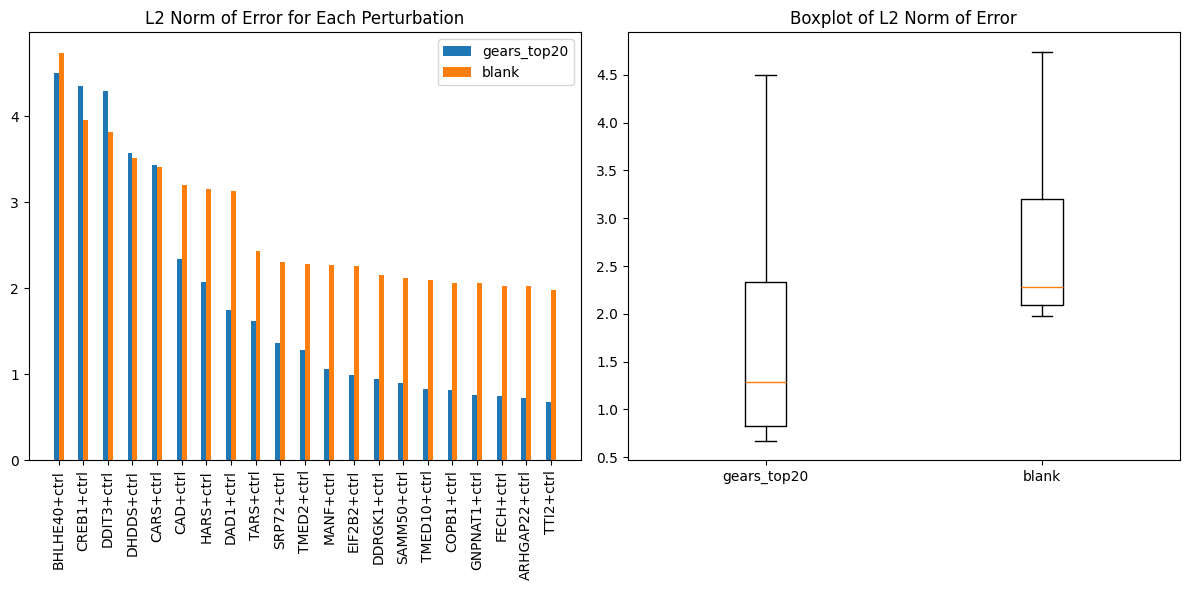

In [19]:
l2_norm_error_blank = cal_l2_error_top20(control_mean_top20_new, Y_true_test_gears_top20_new, perturbations, control_mean_top20_new)
l2_norm_error_gears = cal_l2_error_top20(Y_pred_test_gears_top20_new, Y_true_test_gears_top20_new, perturbations, control_mean_top20_new)

l2_norm_errors_test = {}
l2_norm_errors_test['gears_top20'] = l2_norm_error_gears
l2_norm_errors_test['blank'] = l2_norm_error_blank

plot_outcome(l2_norm_errors_test)

In [20]:
print({method: l2_norm_errors_test[method].mean() for method in l2_norm_errors_test.keys()})

{'gears_top20': np.float32(1.859472), 'blank': np.float32(2.7145858)}


$$
\text{Improvement} = \left( \frac{2.7145858 - 1.859472}{2.7145858} \right) \times 100\% = \text{31.50\%}
$$


In [10]:
model = gears_model.model
gene_emb_weight = model.gene_emb.weight.data.clone().cpu().numpy()
df_gene_emb = pd.DataFrame(gene_emb_weight)
df_gene_emb = df_gene_emb.T
df_gene_emb.columns = pert_data.adata.var['gene_name']
df_gene_emb.to_csv("adamson_gene_emb.csv", index=True)

In [18]:
pert_emb_weight = model.pert_emb.weight.data.clone().cpu().numpy()
df_pert_emb = pd.DataFrame(pert_emb_weight)
df_pert_emb = df_pert_emb.T
perturbations_list = gears_model.pert_list
df_pert_emb.columns = perturbations_list
df_pert_emb.to_csv("adamson_pert_emb.csv", index=True)